In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scene-classification/test_WyRytb0.csv
/kaggle/input/scene-classification/train-scene classification/train.csv
/kaggle/input/scene-classification/train-scene classification/train/19812.jpg
/kaggle/input/scene-classification/train-scene classification/train/22735.jpg
/kaggle/input/scene-classification/train-scene classification/train/16916.jpg
/kaggle/input/scene-classification/train-scene classification/train/7981.jpg
/kaggle/input/scene-classification/train-scene classification/train/22706.jpg
/kaggle/input/scene-classification/train-scene classification/train/20513.jpg
/kaggle/input/scene-classification/train-scene classification/train/12666.jpg
/kaggle/input/scene-classification/train-scene classification/train/13288.jpg
/kaggle/input/scene-classification/train-scene classification/train/20088.jpg
/kaggle/input/scene-classification/train-scene classification/train/6234.jpg
/kaggle/input/scene-classification/train-scene classification/train/1269.jpg
/kaggle/input/scene-c

In [5]:
# Import necessary packages
import numpy as np
import pandas as pd
import os
import keras
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set a random seed for reproducibility
np.random.seed(42)


In [6]:
# Load the dataset
Dataset = pd.read_csv("/kaggle/input/scene-classification/train-scene classification/train.csv") 

# Convert class number to strings
Dataset["label"] = Dataset["label"].astype(str)

# Split the data into train and test subsets
Data_train, Data_test = train_test_split(Dataset, test_size=0.2)

# Define image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Define training set directory
dir1='/kaggle/input/scene-classification/train-scene classification/train/'



In [7]:
# Generate training data
train_gen=datagen.flow_from_dataframe(
    dataframe = Data_train,          
    directory=dir1,                   
    batch_size=20,                    
    class_mode="categorical",         
    x_col="image_name",               
    color_mode="rgb",                 
    y_col="label",                    
    target_size=(224,224))



Found 13627 validated image filenames belonging to 6 classes.


In [8]:
# Generate validation data
valid_gen=datagen.flow_from_dataframe(
    dataframe = Data_test,           
    directory=dir1,                  
    batch_size=20,                   
    class_mode="categorical",        
    x_col="image_name",              
    color_mode="rgb",                
    y_col="label",                   
    target_size=(224,224))



Found 3407 validated image filenames belonging to 6 classes.


In [9]:
import tensorflow as tf

# Load ResNet model for transfer learning
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in ResNet model and add additional layers
for layer in ResNet_model.layers[:-15]:      
    layer.trainable = False

x = ResNet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output  = tf.keras.layers.Dense(units=6, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(ResNet_model.input, output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


234545216/234545216 [==============================] - 1s 0us/step


In [10]:
#Train the model
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit(
    x=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=3)


Epoch 1/3
681/681 [==============================] - 168s 217ms/step - loss: 0.3922 - accuracy: 0.8731 - val_loss: 0.2793 - val_accuracy: 0.9024
Epoch 2/3
681/681 [==============================] - 156s 229ms/step - loss: 0.2362 - accuracy: 0.9197 - val_loss: 0.3030 - val_accuracy: 0.8982
Epoch 3/3
681/681 [==============================] - 156s 229ms/step - loss: 0.1949 - accuracy: 0.9334 - val_loss: 0.3947 - val_accuracy: 0.9065


In [11]:
# Evaluate the model on the test set
test_gen = datagen.flow_from_dataframe(
    dataframe=Data_test,
    directory=dir1,
    batch_size=20,
    class_mode="categorical",
    x_col="image_name",
    color_mode="rgb",
    y_col="label",
    target_size=(224, 224),
    shuffle=False
)

# Reset the test generator
test_gen.reset()

# Predict classes
pred = model.predict(test_gen)

# Convert probabilities to class labels
pred_classes = np.argmax(pred, axis=1)

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Found 3407 validated image filenames belonging to 6 classes.
171/171 [==============================] - 29s 154ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       548
           1       0.99      0.98      0.98       550
           2       0.80      0.86      0.83       599
           3       0.89      0.89      0.89       594
           4       0.96      0.94      0.95       554
           5       0.91      0.85      0.88       562

    accuracy                           0.91      3407
   macro avg       0.91      0.91      0.91      3407
weighted avg       0.91      0.91      0.91      3407



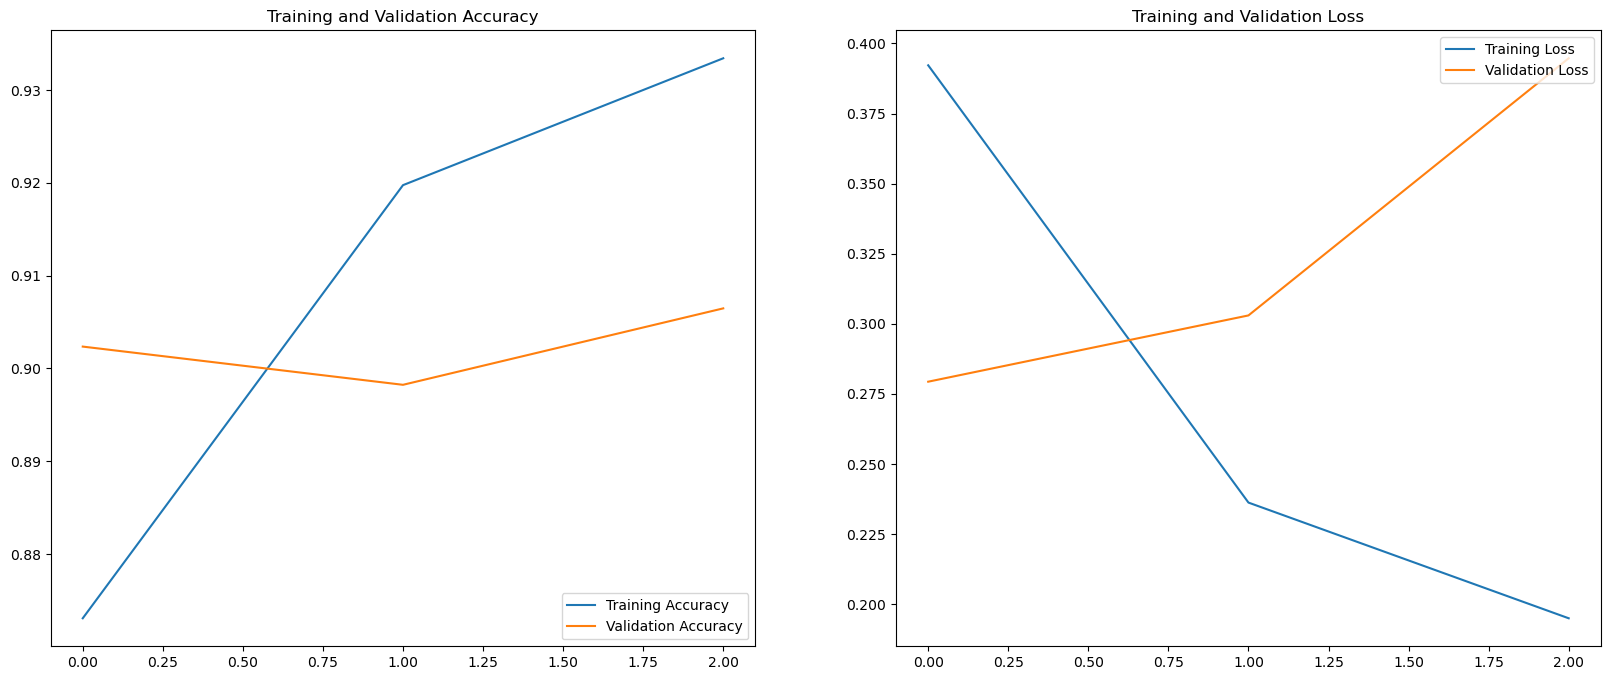

In [12]:
# Plot the training and validation accuracy and loss
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


 **Custom CNN** 

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


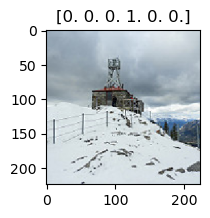

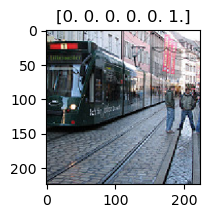

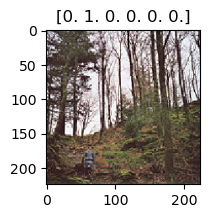

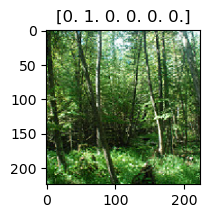

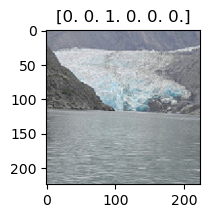

In [21]:
# get a batch of images
images, labels = next(train_gen_cnn)

# display the first 5 images
for i in range(5):
    plt.figure(figsize=(12, 2))
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.show()


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Define the generators
train_gen_cnn = datagen.flow_from_dataframe(
    dataframe=Data_train,
    directory=dir1,
    batch_size=32,
    class_mode="categorical",
    x_col="image_name",
    color_mode="rgb",
    y_col="label",
    target_size=(224, 224),
    subset='training'
)

valid_gen_cnn = datagen.flow_from_dataframe(
    dataframe=Data_train,
    directory=dir1,
    batch_size=32,
    class_mode="categorical",
    x_col="image_name",
    color_mode="rgb",
    y_col="label",
    target_size=(224, 224),
    subset='validation'
)


Found 10902 validated image filenames belonging to 6 classes.
Found 2725 validated image filenames belonging to 6 classes.


In [23]:
# Define a simple model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="best_weights.h5", verbose=1, save_best_only=True)



In [24]:
history = model.fit(
    train_gen_cnn,
    steps_per_epoch=train_gen_cnn.n//train_gen_cnn.batch_size,
    epochs=30,
    validation_data=valid_gen_cnn,
    validation_steps=valid_gen_cnn.n//valid_gen_cnn.batch_size,
    callbacks=[checkpointer, earlystopping]
)

Epoch 1/30
340/340 [==============================] - ETA: 0s - loss: 1.3628 - accuracy: 0.5197
Epoch 1: val_loss improved from inf to 0.96843, saving model to best_weights.h5
340/340 [==============================] - 166s 481ms/step - loss: 1.3628 - accuracy: 0.5197 - val_loss: 0.9684 - val_accuracy: 0.6158
Epoch 2/30
340/340 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.6349
Epoch 2: val_loss improved from 0.96843 to 0.85340, saving model to best_weights.h5
340/340 [==============================] - 173s 510ms/step - loss: 0.9623 - accuracy: 0.6349 - val_loss: 0.8534 - val_accuracy: 0.6724
Epoch 3/30
340/340 [==============================] - ETA: 0s - loss: 0.8623 - accuracy: 0.6783
Epoch 3: val_loss did not improve from 0.85340
340/340 [==============================] - 163s 478ms/step - loss: 0.8623 - accuracy: 0.6783 - val_loss: 0.8924 - val_accuracy: 0.6640
Epoch 4/30
340/340 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.6963


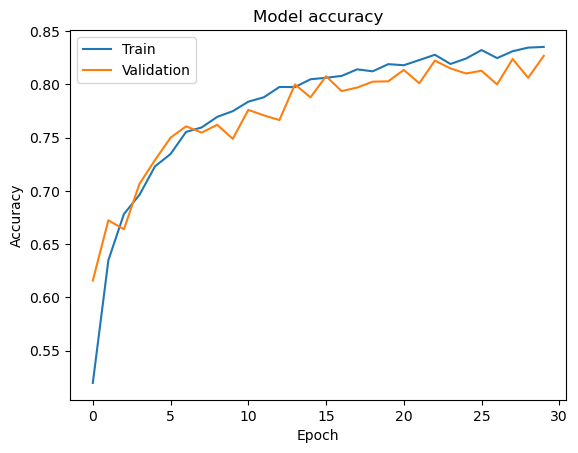

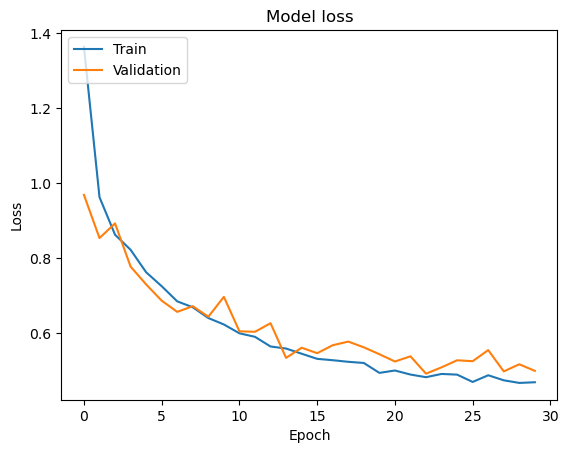

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
